# Indicateur tourisme Côte d'Azur

1ère méthode :  
Essayer de prédire les données officielles à partir des données officielles passées uniquement.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Réduction des données officielles à la Côte d'Azur

In [2]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [3]:
#Base avec les régions :
base_regions_dep = pd.read_csv('departements-region.csv')
base_regions_dep.rename(columns={'dep_name': 'department'}, inplace=True)

In [4]:
#On merge pour rajouter la colonne région
df_France_Official_Data3 = df_France_Official_Data2.merge(base_regions_dep, on='department', how='left')

In [5]:
#Données Côte d'Azur
df_Official_Data_Sud = df_France_Official_Data3[df_France_Official_Data3['region_name']=="Provence-Alpes-Côte d'Azur"]
df_Official_Data_Sud.head(5)

,date,department,value_in_thousands,num_dep,region_name
3,2011-01-01,Alpes-Maritimes,170.80,06,Provence-Alpes-Côte d'Azur
4,2011-01-01,Alpes-de-Haute-Provence,15.27,04,Provence-Alpes-Côte d'Azur
12,2011-01-01,Bouches-du-Rhône,153.08,13,Provence-Alpes-Côte d'Azur
42,2011-01-01,Hautes-Alpes,38.54,05,Provence-Alpes-Côte d'Azur
89,2011-01-01,Var,62.69,83,Provence-Alpes-Côte d'Azur


In [6]:
#On regroupe par mois
df_Official_Data_Sud2 = df_Official_Data_Sud.groupby('date').sum() 
df_Official_Data_Sud2.head(5)

,value_in_thousands
date,
2011-01-01,497.39
2011-02-01,563.17
2011-03-01,722.96
2011-04-01,906.79
2011-05-01,1015.04


## Représentation de la série

<AxesSubplot:xlabel='date'>

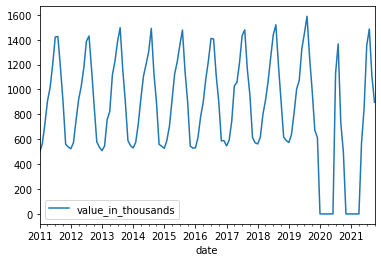

In [7]:
df_Official_Data_Sud2.plot()

/!\ Il y a bcp de valeurs à 0 en 2020 et 2021 avec le covid.

In [8]:
#On se restreint à une période stable ie avant le confinement. On garde les obs avant 2020.
df_Official_Data_Sud2_index = df_Official_Data_Sud2.reset_index()
df_Official_Data_Sud3 = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2020-01-01"]
df_Official_Data_Sud3.set_index('date', inplace=True)
df_Official_Data_Sud3

,value_in_thousands
date,
2011-01-01,497.39
2011-02-01,563.17
2011-03-01,722.96
2011-04-01,906.79
2011-05-01,1015.04
...,...
2019-08-01,1588.56
2019-09-01,1256.16
2019-10-01,986.54


## Stationnarité : Test ADF

In [9]:
#Test ADF

result = adfuller(df_Official_Data_Sud3['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 1.7755045046228788
p-value : 0.9982991765407222
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La statistique ADF est loin des valeurs critiques.   
La p-value est supérieure à 0,05 : on ne rejette pas H0 donc on ne rejette pas l'existence d'une racune unité. Donc la série temporelle n’est pas stationnaire.

### On stationnarise la série

In [10]:
#Différenciation de premier ordre
df_Official_Data_Sud3_diff = df_Official_Data_Sud3 - df_Official_Data_Sud3.shift()
df_Official_Data_Sud3_diff

,value_in_thousands
date,
2011-01-01,NaN
2011-02-01,65.78
2011-03-01,159.79
2011-04-01,183.83
2011-05-01,108.25
...,...
2019-08-01,136.35
2019-09-01,-332.40
2019-10-01,-269.62


Text(0.5, 1.0, 'Série différenciée')

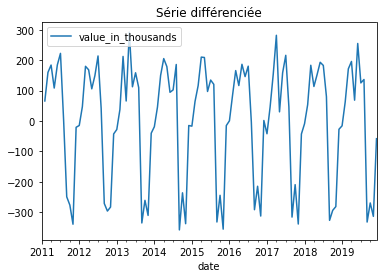

In [11]:
df_Official_Data_Sud3_diff.plot()
plt.title("Série différenciée")

In [12]:
#On supprime le NA 
df_Official_Data_Sud3_diff.dropna(inplace=True)

In [13]:
#Test ADF

result = adfuller(df_Official_Data_Sud3_diff['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -23.038460466365418
p-value : 0.0
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La p-value est <0,05, la série est stationnaire.

## Décomposition

La décomposition d’une série temporelle consiste à séparer sa série initiale en plusieurs sous-séries plus simples, chacune représentant un aspect essentiel de la série initiale. Une décomposition typique est la décomposition en 3 séries: tendance, périodique et reste. On retrouve la série originale si on somme les 3 séries composantes.

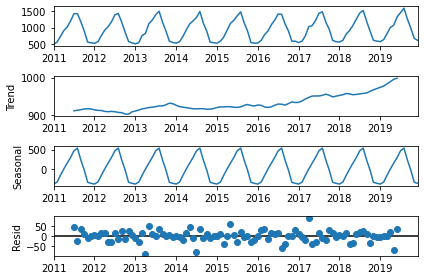

In [14]:
decompose = seasonal_decompose(df_Official_Data_Sud3, period=12)
decompose.plot()
plt.show()

## Fonction d'auto-corrélation (ACF) et d'auto-corrélation partielle (PACF)

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :  
p : nombre de termes autorégressifs (ordre AR)  
d : nombre de différences non saisonnières (ordre de différenciation)  
q : nombre de termes moyens mobiles (ordre MA)  

Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. 

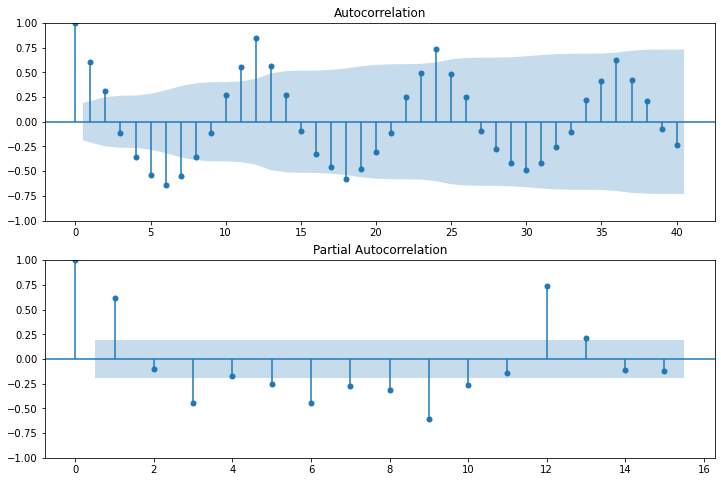

In [15]:
#sur la série différenciée

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Official_Data_Sud3_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Official_Data_Sud3_diff, lags=15, ax=ax2); 

## Modèle ARIMA

### Choix du modèle qui minimise l'AIC et le BIC

In [16]:
def choix_modele_arima(pmax, dmax, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    d = range(0, dmax)
    pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q

    parametres = {} # stores aic and order pairs
    parametres_bic = {}
    aics = [] # stores aics
    bics = []

    # Grid Search continued
    for param in pdq:
        try:
            model = ARIMA(data, order=param) # create all possible models
            model = model.fit()
            parametres.update({model.aic : param}) # store combinations
            parametres_bic.update({model.bic : param}) # store combinations
            aics.append(model.aic)
            bics.append(model.bic)

        except:
            continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(best_aic)
    print(parametres[best_aic])

    print(best_bic)
    print(parametres_bic[best_bic])

In [17]:
#choix_modele_arima(4,3,4, df_Official_Data_Sud3)

### Modèle ARIMA

On crée et ajuste un modèle ARIMA avec un AR d’ordre 2, une différence d’ordre 1 et un MA d’ordre 3.

In [18]:
model = ARIMA(df_Official_Data_Sud3, order=(2,1,3)) #(p,d,q)
results_ARIMA = model.fit()
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     value_in_thousands   No. Observations:                  108
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -631.272
Date:                Thu, 12 May 2022   AIC                           1274.545
Time:                        18:24:17   BIC                           1290.582
Sample:                    01-01-2011   HQIC                          1281.046
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7282      0.013    138.152      0.000       1.704       1.753
ar.L2         -0.9948      0.012    -83.970      0.000      -1.018      -0.972
ma.L1         -2.4606      0.137    -17.971      0.000      -2.729      -2.192
ma.L2          2.0425      0.259      7.886      0.000       1.535       2.550
ma.L3         -0.5630      0.133     -4.235      0.000      -0.824      -0.302
sigma2      7964.2458   1541.078      5.168      0.000    4943.789     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.07   Prob(JB):                         0.27
Heteroskedasticity (H):               1.25   Skew:                             0.38
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tous les coeff sont significatifs car les p-values sont inférieures à 5%.

### Résidus

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7282      0.013    138.152      0.000       1.704       1.753
ar.L2         -0.9948      0.012    -83.970      0.000      -1.018      -0.972
ma.L1         -2.4606      0.137    -17.971      0.000      -2.729      -2.192
ma.L2          2.0425      0.259      7.886      0.000       1.535       2.550
ma.L3         -0.5630      0.133     -4.235      0.000      -0.824      -0.302
sigma2      7964.2458   1541.078      5.168      0.000    4943.789     1.1e+04


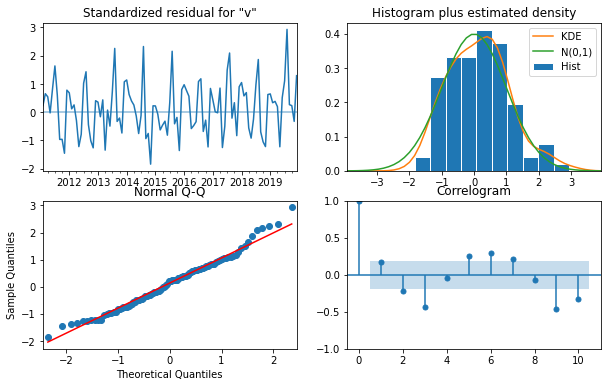

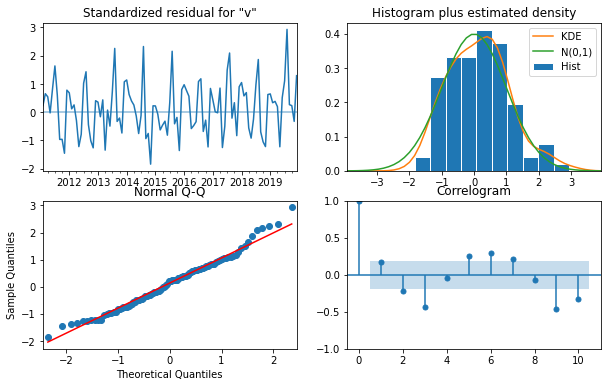

In [19]:
print(results_ARIMA.summary().tables[1])
#Check residuals
results_ARIMA.plot_diagnostics(figsize=(10, 6))

Les résidus ont quelques autocorrélations en dehors de l'intervalle de confiance.

### Test portmanteau

In [20]:
residuals = pd.DataFrame(results_ARIMA.resid)
sm.stats.acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,3.425944,6.417953e-02
2,4.794136,9.098434e-02
3,13.522040,3.633498e-03
4,13.670016,8.426226e-03
5,20.115106,1.189070e-03
6,30.839057,2.720715e-05
7,34.476036,1.402737e-05
8,35.960841,1.785239e-05
9,53.470542,2.379807e-08
10,65.540133,3.194692e-10


Les p-value sont faibles (toutes <5% sauf au lag 4) : on rejette le modèle ARIMA(2,1,3)

### Prédiction

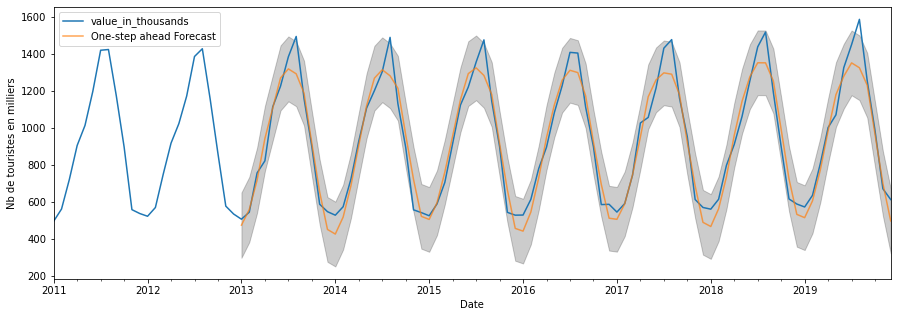

In [21]:
#A partir de 2013, on compare la prédiction aux valeurs officielles
pred = results_ARIMA.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_Official_Data_Sud3['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Nb de touristes en milliers')
plt.legend()
plt.show()

#### RMSE

In [22]:
df_forecasted = pred.predicted_mean
df_truth = df_Official_Data_Sud3['2013-01-01':]

rmse = mean_squared_error(df_truth, df_forecasted, squared=False)
rmse

84.72478167429796

## SARIMA

The models notation is SARIMA(p, d, q).(P,D,Q)m

### Choix du modèle avec les AIC

In [52]:
def choix_modele_sarima(pmax, d, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    pdq = [(p,d,q) for p,q in itertools.product(p,q)]

    p2 = q2 = range(0, 2)
    seasonal_pdq = [(p2,d,q2) for p2,q2 in itertools.product(p2,q2)]
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    print(best_aic)
    print(parametres_aic[best_aic])

    best_bic = min(bics)
    print(best_bic)
    print(parametres_bic[best_bic])
    
    return([aics, parametres_aic, bics, parametres_bic])

In [54]:
choix_modele_sarima(6,1,3, df_Official_Data_Sud3)

794.5537147058886
[(5, 1, 0), (1, 1, 1, 12)]
813.4073853194054
[(5, 1, 0), (1, 1, 1, 12)]


[[1030.914030553913,
  886.0114597207203,
  907.1030791906593,
  886.6242943982726,
  962.5174222802422,
  822.8781099225749,
  849.9921321282023,
  824.8496174494885,
  954.8646640181671,
  810.6218294691515,
  850.1126980146983,
  812.4752709644882,
  1005.0618069211358,
  860.3001117158047,
  872.8561568517412,
  861.6932437234029,
  964.429526690391,
  823.4496690385118,
  840.5790263099448,
  825.4221317478438,
  956.8873845668303,
  813.1605497844103,
  841.5945874164354,
  814.4353489176557,
  985.2631141164519,
  848.6480251562145,
  849.5961469182292,
  840.8118917443567,
  966.395012949057,
  825.0586573799067,
  831.2650902931788,
  827.0586483682872,
  958.8283432479349,
  813.7773923080206,
  833.2410223469631,
  815.7075548892283,
  964.8674561187462,
  843.2484985471243,
  828.8746067378061,
  822.4348529202755,
  958.8243489634315,
  827.0326550439738,
  819.718951375705,
  815.6505449261253,
  960.3734710695213,
  815.6576701998898,
  821.7155942383661,
  817.635699912

### Modélisation

In [49]:
mod = sm.tsa.statespace.SARIMAX(df_Official_Data_Sud3,
                                order=(5, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   value_in_thousands   No. Observations:                  108
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -389.277
Date:                              Thu, 12 May 2022   AIC                            794.554
Time:                                      18:39:24   BIC                            813.407
Sample:                                  01-01-2011   HQIC                           802.101
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9363      0.122     -7.659      0.000      -1.176      -0.697
ar.L2         -0.79

### Résidus

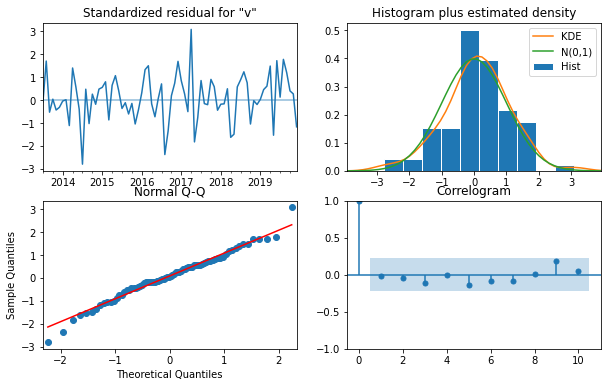

In [50]:
results_SARIMA.plot_diagnostics(figsize=(10, 6))
plt.show()

Le graphique de autocorrélations des résidus est bien.

### Tests portmanteaux

In [27]:
residuals_SARIMA = pd.DataFrame(results_SARIMA.resid)
sm.stats.acorr_ljungbox(residuals_SARIMA)

,lb_stat,lb_pvalue
1,49.209163,2.300735e-12
2,77.764854,1.298902e-17
3,88.044426,5.761534e-19
4,89.383132,1.780473e-18
5,89.420396,8.893417e-18
6,90.995748,1.881747e-17
7,97.349494,3.801201e-18
8,108.485253,7.795253e-20
9,120.849498,8.952289e-22
10,133.839424,7.682210e-24


Les p-value sont toutes <5% : on rejette le modèle SARIMAX(0, 2, 3)x(0, 1, 1, 12)

### Prévision

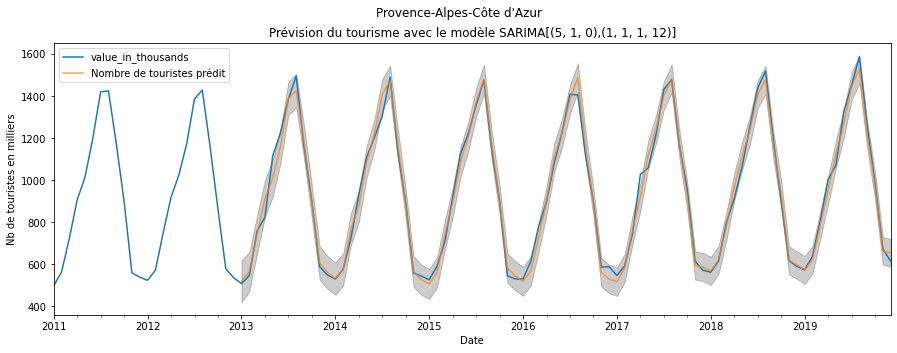

In [51]:
pred = results_SARIMA.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_Official_Data_Sud3['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Nombre de touristes prédit', alpha=.7, figsize=(15, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Nb de touristes en milliers')
plt.legend()
plt.title('Prévision du tourisme avec le modèle SARIMA[(5, 1, 0),(1, 1, 1, 12)]')
plt.suptitle("Provence-Alpes-Côte d'Azur")
plt.show()

#### RMSE

In [29]:
df_forecasted = pred.predicted_mean
df_truth = df_Official_Data_Sud3['2013-01-01':]

rmse = mean_squared_error(df_truth, df_forecasted, squared=False)
rmse

38.009972217427396

#### Prédiction valeurs futures

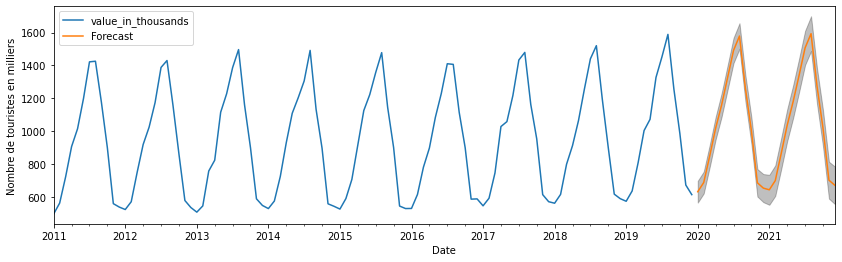

In [30]:
pred_uc = results_SARIMA.get_forecast(steps=24) #je prédis le nombre de touristes pour les 24 prochains mois
pred_ci = pred_uc.conf_int()
ax = df_Official_Data_Sud3.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de touristes en milliers')
plt.legend()
plt.show()

## Prédiction en temps réel, qui intègre les nouvelles données --> boucle for

In [31]:
df_Official_Data_Sud2.head(3)

,value_in_thousands
date,
2011-01-01,497.39
2011-02-01,563.17
2011-03-01,722.96


In [32]:
df_Official_Data_Sud2_index.head(3)

,date,value_in_thousands
0,2011-01-01,497.39
1,2011-02-01,563.17
2,2011-03-01,722.96


On suppose qu'on a toutes les données jusqu'à fin 2017, qu'on n'a pas encore les données suivantes, et qu'on les ajoute au fur et à mesure.

In [33]:
#on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponibles
df_donnees_dispo = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2018-01-01"]
df_donnees_dispo.set_index('date', inplace=True)

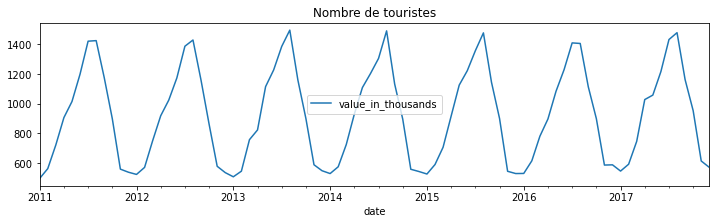

In [34]:
df_donnees_dispo.plot(figsize=(12, 3), title='Nombre de touristes');

In [35]:
#choix_modele_sarima(6,1,3,df_donnees_dispo)

In [36]:
#on fit le modèle SARIMA(5, 1, 0)x(1, 1, 0, 12) sur ces données
modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                        order=(5, 1, 0),
                                        seasonal_order=(1, 1, 0, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

resultats_prev = modele_prev.fit()
resultats_prev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 value_in_thousands   No. Observations:                   84
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -270.611
Date:                            Thu, 12 May 2022   AIC                            555.222
Time:                                    18:29:34   BIC                            569.145
Sample:                                01-01-2011   HQIC                           560.591
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0798      0.152     -7.084      0.000      -1.379      -0.781
ar.L2         -1.0794      0.248     -4.351      0.000      -1.566      -0.593
ar.L3         -0.8430      0.232     -3.626      0.000      -1.299      -0.387
ar.L4         -0.4803      0.244     -1.967      0.049      -0.959      -0.002
ar.L5         -0.1949      0.187     -1.042      0.297      -0.561       0.172
ar.S.L12      -0.4971      0.158     -3.141      0.002      -0.807      -0.187
sigma2      1319.1697    244.774      5.389      0.000     839.422    1798.917
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.95   Prob(JB):                         0.84
Heteroskedasticity (H):               1.46   Skew:                             0.04
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

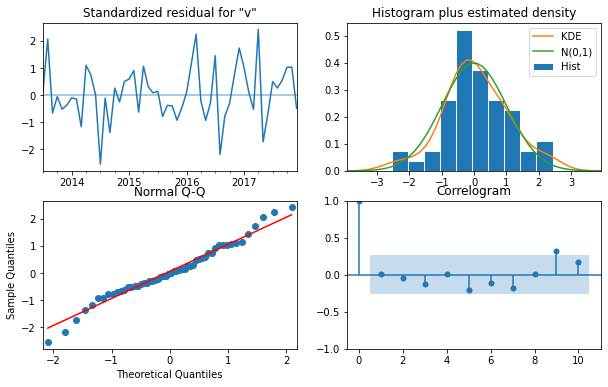

In [37]:
resultats_prev.plot_diagnostics(figsize=(10, 6))
plt.show()

In [38]:
sm.stats.acorr_ljungbox(pd.DataFrame(resultats_prev.resid))

,lb_stat,lb_pvalue
1,43.039772,5.363831e-11
2,66.386396,3.840407e-15
3,74.513897,4.605608e-16
4,75.473945,1.581856e-15
5,75.496026,7.329795e-15
6,77.053730,1.448865e-14
7,82.827474,3.646605e-15
8,93.596815,8.637274e-17
9,105.762441,1.069131e-18
10,116.528744,2.557564e-20


In [39]:
#on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
df_forecast['date'] = df_Official_Data_Sud2_index['date'][(df_Official_Data_Sud2_index['date']<'2021-10-01') &
                                                           (df_Official_Data_Sud2_index['date']>="2018-01-01")]
df_forecast.set_index('date', drop=False, inplace=True)

df_forecast.head(3)

,date,valeur_predite,donnee_officielle
date,,,
2018-01-01,2018-01-01,NaN,NaN
2018-02-01,2018-02-01,NaN,NaN
2018-03-01,2018-03-01,NaN,NaN


In [40]:
resultats_prev_new = resultats_prev

for date in df_forecast['date']:
      
    #La valeur prédite :
    if ( float(resultats_prev_new.forecast(date)) >= 0):
        df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date))
    else:
        df_forecast.loc[date, 'valeur_predite'] = 0
    #je mets dans le dataframe la prédiction pour la date

    # La nouvelle observation qu'on a à disposition
    new_data = df_Official_Data_Sud2.loc[date, "value_in_thousands"]
    
    #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
    new_data2 = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']==date]
    new_data2.set_index('date', inplace=True)
        
    #On met la nouvelle observation dans le dataframe
    df_forecast.loc[date, 'donnee_officielle'] = new_data
    
    #Nouveau modèle fitté avec une donnée de plus :
    resultats_prev_new = resultats_prev_new.append(new_data2)

df_forecast    


,date,valeur_predite,donnee_officielle
date,,,
2018-01-01,2018-01-01,582.425875,562.43
2018-02-01,2018-02-01,649.604038,615.98
2018-03-01,2018-03-01,804.914431,799.13
2018-04-01,2018-04-01,994.814891,912.49
2018-05-01,2018-05-01,1099.538418,1064.31
2018-06-01,2018-06-01,1245.668863,1257.36
2018-07-01,2018-07-01,1427.513228,1439.99
2018-08-01,2018-08-01,1433.673851,1519.95
2018-09-01,2018-09-01,1130.567635,1193.16


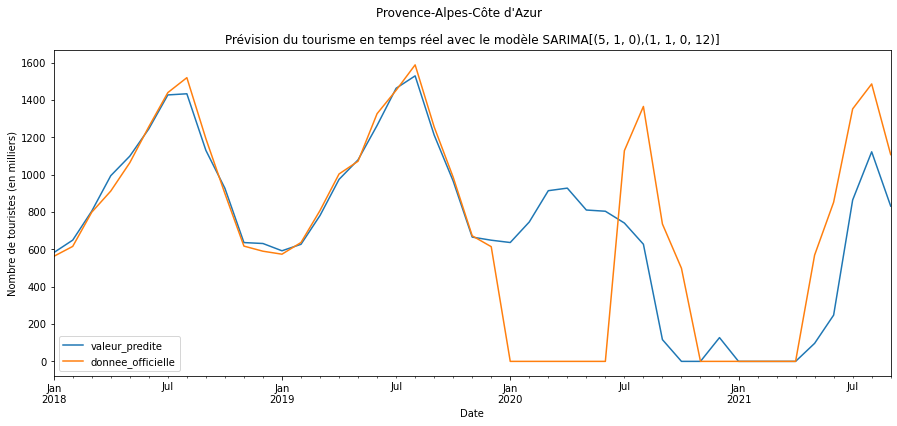

In [41]:
df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers)")
plt.title('Prévision du tourisme en temps réel avec le modèle SARIMA[(5, 1, 0),(1, 1, 0, 12)]')
plt.suptitle("Provence-Alpes-Côte d'Azur")
plt.legend()

In [42]:
#RMSE 2017-2021 en temps réel
rmse_touteperiode = mean_squared_error(df_forecast['donnee_officielle'], df_forecast['valeur_predite'], squared=False)

print(rmse_touteperiode)


#RMSE 2017-dec2019 en temps réel
df_forecasted_tempsreel = df_forecast.loc[:"2019-12-01", 'valeur_predite']
df_truth_tempsreel = df_forecast.loc[:"2019-12-01", 'donnee_officielle']

rmse_avcovid_tempsreel = mean_squared_error(df_forecasted_tempsreel, df_truth_tempsreel, squared=False)

print(rmse_avcovid_tempsreel)


#RMSE 2017-dec2019 pas en temps réel
df_forecasted_pastempsreel = pred.predicted_mean['2017-01-01':]
df_truth_pastempsreel = df_Official_Data_Sud3['2017-01-01':]

rmse_avantcovid_pastempsreel = mean_squared_error(df_truth_pastempsreel, df_forecasted_pastempsreel, squared=False)

print(rmse_avantcovid_pastempsreel)

376.599734177454
39.40298600901271
36.165105803786666


#### Méthode 1 : Utiliser le modèle fitté de janvier 2011 à décembre 2016 et utiliser les coefficients obtenus pour les appliquer ensuite aux nouvelles données

In [43]:
coeff_modele = resultats_prev.params
print(coeff_modele)

coeff_MA1 = coeff_modele[0]
coeff_MA2 = coeff_modele[1]
coeff_MA3 = coeff_modele[2]
coeff_maSL12 = coeff_modele[3]
coeff_sigma2 = coeff_modele[4]

ar.L1         -1.079792
ar.L2         -1.079421
ar.L3         -0.843042
ar.L4         -0.480317
ar.L5         -0.194856
ar.S.L12      -0.497051
sigma2      1319.169692
dtype: float64


In [44]:
#on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

df_forecast_meth1 = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
df_forecast_meth1['date'] = df_Official_Data_Sud2_index['date'][(df_Official_Data_Sud2_index['date']<'2021-10-01') &
                                                                   (df_Official_Data_Sud2_index['date']>="2017-01-01")]
df_forecast_meth1.set_index('date', drop=False, inplace=True)

df_forecast_meth1.head(3)

,date,valeur_predite,donnee_officielle
date,,,
2017-01-01,2017-01-01,NaN,NaN
2017-02-01,2017-02-01,NaN,NaN
2017-03-01,2017-03-01,NaN,NaN


Prédiction janvier 2017 : si tu avais un ARMA (1,0,0), tu récupères la valeur officielle de décembre 2016 et tu appliques le coefficient associé à l'AR1 trouvé lorsque tu as fitté ton ARMA de janvier 2011 à décembre 2016  
Prédiction février 2017 : si tu avais un ARMA (1,0,0), tu récupères la valeur officielle de janvier 2017 et tu appliques le coefficient associé à l'AR1 trouvé lorsque tu as fitté ton ARMA de janvier 2011 à décembre 2016

In [45]:
#for date in df_forecast_meth1['date']:
      
    # La nouvelle observation qu'on a à disposition
    #new_data = df_Official_Data_Sud2.loc[date, "value_in_thousands"]
           
    #On met la nouvelle observation dans le dataframe
    #df_forecast_meth1.loc[date, 'donnee_officielle'] = new_data
    
    #La valeur prédite :
    #df_forecast.loc[date, 'valeur_predite'] = #appliquer les coeff stockés dans les variables à la valeur officielle précédente................. 
    #je mets dans le dataframe la prédiction pour la date
    

#df_forecast_meth1